In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import numpy as np

%matplotlib inline  

In [2]:
references = pd.read_csv('data/References.csv', index_col=0)

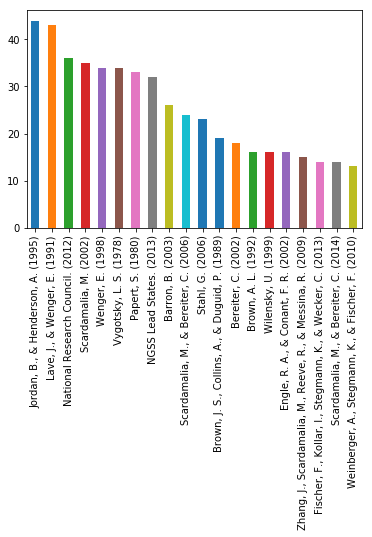

In [3]:
references.ref_parsed.value_counts().head(20).plot(kind='bar')

# get document identifier

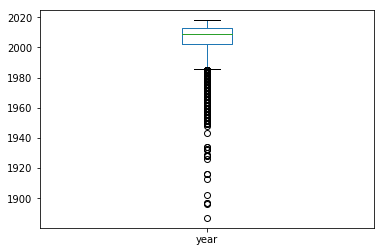

In [4]:
references.year.plot(kind='box')

In [5]:
references.head()

,ref,file,ref_parsed,year,identifier
0,"Lave, J., & Wenger, E. (1991). Situated learni...",import2018_371,"Lave, J., & Wenger, E. (1991)",1991.0,"Lave, J., & Wenger, E. (1991). Situated learni..."
1,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",import2018_371,"Miles, M. B., Huberman, A. M., & Saldana, J. (...",2013.0,"Miles, M. B., Huberman, A. M., & Saldana, J. (..."
2,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",import2018_371,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish...",1997.0,"Pea, R. D., Gomez, L. M., Edelson, D. C., Fish..."
3,"Rogoff, B. (1995). Observing sociocultural act...",import2018_371,"Rogoff, B. (1995)",1995.0,"Rogoff, B. (1995). Observing sociocultural act..."
4,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",import2018_371,"Shirk, J., Ballard, H., Wilderman, C., Phillip...",2012.0,"Shirk, J., Ballard, H., Wilderman, C., Phillip..."


In [6]:
sample = references[['ref', 'identifier']].sample(4)
sample.ref.tolist()

["Harris, A., Rick, J., Bonnett, V., Yuill, N., Fleck, R., Marshall, P., & Rogers, Y. (2009). Around the table: Are multiple-touch surfaces better than single-touch for children's collaborative interactions? In Proceedings of the CSCL 2009 (pp. 335–344). ISLS.",
 'Haas, C. (1999). On the relationship between old and new technologies. Computers and Composition, 16(2), 209-228.',
 'Inayat, I., ul Amin, R., Inayat, Z., & Salim, S. S. (2013). Effects of collaborative web based vocational education and training (VET) on learning outcomes. Computers & Education, 68, 153-166.',
 'Tinto, V. (1975). Dropout from Higher Education: A Theoretical Synthesis of Recent Research. Review of Educational Research Winter, 45(1), 89–125.']

In [7]:
sample.identifier.tolist()

["Harris, A., Rick, J., Bonnett, V., Yuill, N., Fleck, R., Marshall, P., & Rogers, Y. (2009). Around the table: Are multiple-touch surfaces better than single-touch for children's collaborative interactions",
 'Haas, C. (1999). On the relationship between old and new technologies',
 'Inayat, I., ul Amin, R., Inayat, Z., & Salim, S. S. (2013). Effects of collaborative web based vocational education and training (VET) on learning outcomes',
 'Tinto, V. (1975). Dropout from Higher Education: A Theoretical Synthesis of Recent Research']

# Merge names with references:

In [27]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0)

In [28]:
reference_authors = pd.read_csv('data/Reference_authors.csv', index_col=0)
reference_authors.shape

(34668, 2)

In [29]:
reference_authors.drop_duplicates(inplace=True)
reference_authors.shape

(29778, 2)

In [30]:
reference_authors.head()

,author,file
0,Lave J.,import2018_371
1,Wenger E.,import2018_371
2,Miles M. B.,import2018_371
3,Huberman A. M.,import2018_371
4,Saldana J.,import2018_371


In [32]:
reference_edges = pd.merge(metadata, reference_authors, on='file')[['shortend_names', 'author']]

In [33]:
reference_edges

,shortend_names,author
0,Jeong H.,Arnseth H. C.
1,Jeong H.,Ludvigsen S.
2,Jeong H.,Becker H. S.
3,Jeong H.,Geer B.
4,Jeong H.,Beers P. J.
5,Jeong H.,Boshuizen H. P.
6,Jeong H.,K
7,Jeong H.,irschner P. A.
8,Jeong H.,Gijselaers W. H.
9,Jeong H.,Bergin D. A.


In [35]:
reference_edges.columns = ['author', 'cited']

People who like to cite themselves:

In [36]:
reference_edges[reference_edges.author == reference_edges.cited].author.value_counts().head()

Zhang J.          10
Puntambekar S.     9
Rummel N.          9
Blikstein P.       9
Sharma K.          7
Name: author, dtype: int64

In [37]:
set(reference_edges.author.tolist()) in set(reference_edges.cited.tolist())

False

In [38]:
print('Number of distinct authors ', len(reference_edges.author.unique()))
print('Number of distinct cited authors by some author in the conference ', len(reference_edges.cited.unique()))
print('Number of authors that where cited by an other author in the confernce :' , len(set(reference_edges.cited.tolist()).intersection(set(reference_edges.author.tolist()))))

Number of distinct authors  1481
Number of distinct cited authors by some author in the conference  10405
Number of authors that where cited by an other author in the confernce : 758


In [39]:
not_in_conference = list(set(reference_edges.cited) - set(reference_edges.author))

In [40]:
reference_edges['participated'] = reference_edges.cited.map(lambda x : 0 if x in not_in_conference else 1)

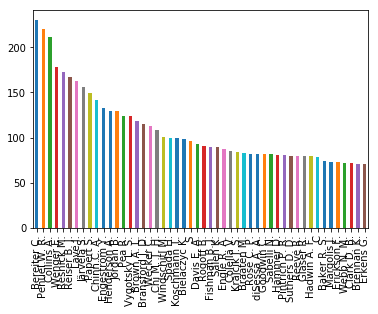

In [41]:
reference_edges[reference_edges.participated == 0].cited.value_counts().head(50).plot(kind = 'bar')

## References

In [42]:
references = pd.read_csv('data/References.csv', index_col=0)

In [43]:
references.ref.sample(5).tolist()

['Prieto, L. P., Dlab, M. H., Gutiérrez, I., Abdulwahed, M., & Balid, W. (2011). Orchestrating technology enhanced learning: a literature review and a conceptual framework. International Journal of Technology Enhanced Learning, 3(6), 583-598.',
 'Hall, R. (1999). The organization and development of discursive practices for “having a theory”. Discourse Processes, 27(2), 187-218.',
 'Anderson, L. W., & Krathwohl, D. R. (2001). A Taxonomy for Learning, Teaching, and Assessing: A Revision of Bloom’s Taxonomy of Educational Objectives. New York, NY: Longman De Jong, O., & Taber, K. S. (2014). The Many Faces of High School Chemistry. In N. Lederman & S. K. Abell (Eds.), Handbook of Research on Science Education (pp. 457-480). New York, NY: Routledge.',
 '* Chang, C.-C., & Tseng, K.-H. (2011). Using a web-based portfolio assessment system to elevate project-based learning performances. Interactive Learning Environments, 19, 211-230. doi:10.1080/10494820902809063',
 'Jant, E. A., Haden, C. A.,

# Building the refrence graph:

directed graph weighted by number of times x cited y:

In [44]:
nodes = pd.DataFrame(reference_edges.author.drop_duplicates().reset_index(drop=True)).reset_index()

In [45]:
nodes.head()

,index,author
0,0,Jeong H.
1,1,Hmelo-Silver C. E.
2,2,Wake J. D.
3,3,Guribye F.
4,4,Wasson B.


In [46]:
edges = pd.merge(nodes, reference_edges, left_on='author', right_on='cited')
del edges['author_x'], edges['participated']

In [47]:
edges = pd.merge(nodes, edges, left_on='author', right_on='author_y')
del edges['author_y'], edges['author'], edges['cited']

In [48]:
edges.columns = ['author', 'citation']
edges

,author,citation
0,0,0
1,0,0
2,0,0
3,0,1
4,0,1
5,0,1
6,0,11
7,0,11
8,0,11
9,0,40


In [49]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for idx, row in edges.iterrows():
    if np.isnan(row.author):
        continue
    i, j = int(row.author), int(row.citation)
    adjacency[j, i] += 1

In [50]:
adjacency.shape

(1481, 1481)

In [51]:
degrees = np.where(adjacency > 0, 1, 0).sum(axis=0)

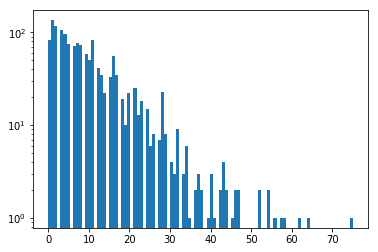

In [52]:
plt.hist(degrees, bins=100, log=True)
plt.show()

In [53]:
import networkx as nx

graph = nx.from_numpy_array(adjacency)

mapping = nodes.author.to_dict()

H=nx.relabel_nodes(graph,mapping)
print(sorted(H.nodes()))

nx.write_gexf(H, 'data/refrence_graph.gexf')

[' Adams', ' Barnes', ' Bedell', ' Ben', ' Clark', ' J.', ' J. Z.', ' M.', ' Swearingen', ' Virk', '-Horin H.', 'Aalst J.', 'Abdu R.', 'Abelein H.', 'Abelson H.', 'Abrahamson D.', 'Acharya A.', 'Acosta A.', 'Adams J. A.', 'Adams J. D.', 'Adanır G. A.', 'Addeh A.', 'Agarwal P.', 'Agrawal H.', 'Ahn J.', 'Ainsworth S.', 'AlQahtani M.', 'Albrecht J.', 'Aleven V.', 'Allen S.', 'Allert H.', 'Almatrafi O.', 'Alozie N.', 'Amersfoort D.', 'Amici-Dargan S. L.', 'Amzalag M.', 'Anderson A.', 'Anderson C. W.', 'Anderson E.', 'Anderson J. L.', 'Anderson R. C.', 'Anderson R. K.', 'Anderson T. D.', 'Anderson-Levitt K.', 'Andrade A.', 'Andrews C. J.', 'Angelo C.', 'Angersbach J.', 'Antle A. N.', 'Anton G.', 'Apollonia S.', 'Applebaum L.', 'Applebaum L. R.', 'Arastoopour G.', 'Archibeque B. A.', 'Arend B.', 'Arias A. M.', 'Arnedillo-Sanchez I.', 'Arukovic S.', 'Asaridou S. S.', 'Asino T. I.', 'Askari E.', 'Asterhan C.', 'Atarashi E.', 'Atit K.', 'Av-Shalom N. Y.', 'Avry S.', 'Ayer T.', 'Azevedo R.', 'Ba